In [202]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

np.random.seed(9876789)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [36]:
nsample = 100
x = np.linspace(0, 10, 100)
X = np.column_stack((x, x**2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)
X = sm.add_constant(X)
y = np.dot(X, beta) + e

In [51]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.020e+06
Date:                Sat, 15 Aug 2020   Prob (F-statistic):          2.83e-239
Time:                        17:42:31   Log-Likelihood:                -146.51
No. Observations:                 100   AIC:                             299.0
Df Residuals:                      97   BIC:                             306.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3423      0.313      4.292      0.0

In [67]:
print('Coefficients: ', results.params)
print('R2: ', results.rsquared)
print('Standard errors of each parameter: ', results.bse)
y_pred = results.predict()

Coefficients:  [1.342 -0.040 10.010]
R2:  0.9999879365025871
Standard errors of each parameter:  [0.313 0.145 0.014]


In [129]:
#Comparison with Sklearn Linear Regression
skmodel = LinearRegression()
skmodel.fit(X,y)
print('Coefficients: ',skmodel.intercept_, skmodel.coef_)
print("R2 Score :", r2_score(y, y_pred))
rmse = mean_squared_error(y, y_pred, squared=False)
print("RMSE/Standard Error: %.2f" % rmse)
sk_pred = skmodel.predict(X)

Coefficients:  1.3423351563678807 [0.000 -0.040 10.010]
R2 Score : 0.9999879365025871
RMSE/Standard Error: 1.05


In [93]:
#Calculate const coefficient
x1_mean = np.mean(X[:,1])
x2_mean = np.mean(X[:,2])
Y_mean = np.mean(y)
const_coeff = Y_mean - (x1_mean * (-0.0402) + x2_mean  * (10.0103))
print('Const Coefficient: ', const_coeff)
#t-statistics
t_stat = np.array([])
for p, e in zip(results.params, results.bse):
    t_stat = np.append(t_stat, p/e)
print('t-stat:', t_stat)

Const Coefficient:  1.3405323831764235
t-stat: [4.292 -0.278 715.745]


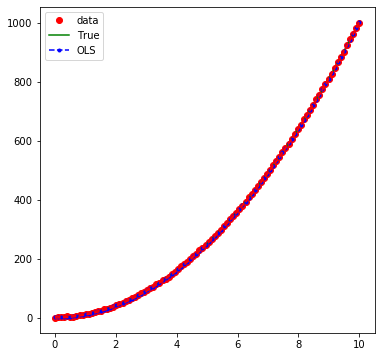

In [220]:
predstd, lower, upper = wls_prediction_std(results)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x,y, 'ro', label='data')
ax.plot(x, y_pred, 'g-', label="True")
ax.plot(x, results.fittedvalues, 'b--.', label="OLS")
ax.plot(x, upper, 'r--')
ax.plot(x, lower, 'r--')
ax.legend(loc='best');

VIF for each parameters: [8.649388468258591, 15.707382953181284, 15.707382953181284]


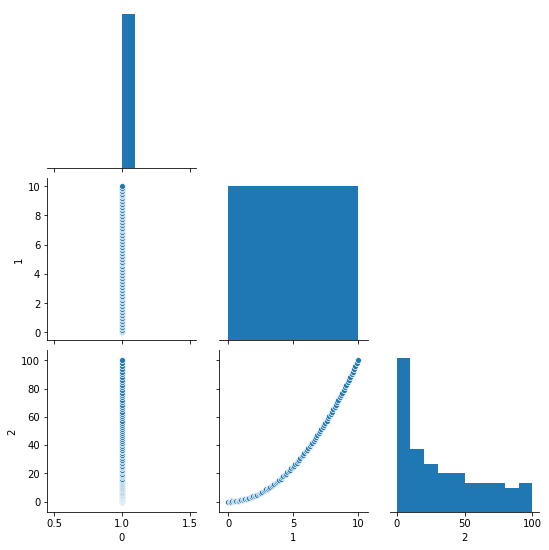

In [183]:
#check for multicollinearity
vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print("VIF for each parameters:", vif)
sns.pairplot(data=pd.DataFrame(X), corner=True)

MEan of residual (should be closer to 0): -3.326361408539924e-13


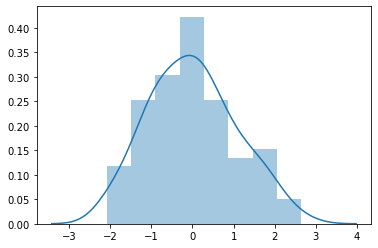

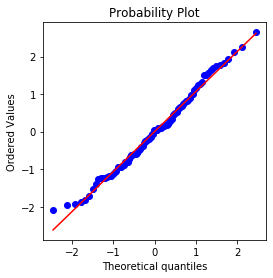

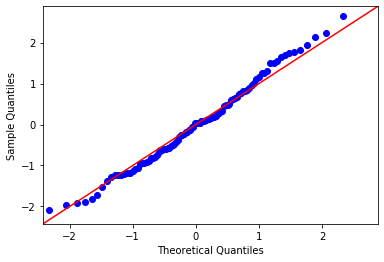

In [234]:
#normal distribution of error terms
sns.distplot(residuals)

plt.figure(figsize=(4,4))
stats.probplot(results.resid, dist="norm", plot=plt)
sm.qqplot(results.resid, line ='45') 
print("MEan of residual (should be closer to 0):", np.mean(results.resid))

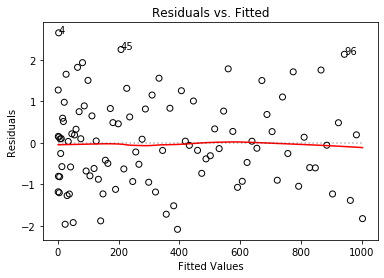

In [217]:
#linrarity (residual vs fitted plot)
smoothed = lowess(results.resid, results.fittedvalues)
top3 = abs(pd.Series(results.resid)).sort_values(ascending = False)[:3]
fig, ax = plt.subplots()
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.scatter(results.fittedvalues, results.resid, edgecolors = 'k',  facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.plot([min(results.fittedvalues),max(results.fittedvalues)],[0,0],color = 'k',linestyle = ':', alpha = .3)
for i in top3.index:
    ax.annotate(i,xy=(results.fittedvalues[i],results.resid[i]))


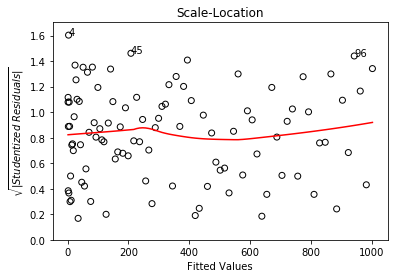

In [233]:
#heteroscedasticity - scale location plot
student_residuals = results.get_influence().resid_studentized_internal
sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
sqrt_student_residuals.index = pd.Series(results.resid).index
smoothed = lowess(sqrt_student_residuals, results.fittedvalues)
top3 = abs(sqrt_student_residuals).sort_values(ascending = False)[:3]
fig, ax = plt.subplots()
ax.scatter(results.fittedvalues, sqrt_student_residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
ax.set_xlabel('Fitted Values')
ax.set_title('Scale-Location')
ax.set_ylim(0,max(sqrt_student_residuals)+0.1)
for i in top3.index:
    ax.annotate(i,xy=(results.fittedvalues[i],sqrt_student_residuals[i]))